## IMPORTS

In [0]:
!pip install mne

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets.sleep_physionet.age import fetch_data

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## DATASET PREPROCESSING

In [0]:
def build_dataset(start, end):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(start, end)]
  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1,
                                'Sleep stage 1': 2,
                                'Sleep stage 2': 3,
                                'Sleep stage 3': 4,
                                'Sleep stage 4': 4,
                                'Sleep stage R': 5}
  event_id = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage 3/4': 4,
              'Sleep stage R': 5}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = 0
  for file in files:
      raw = mne.io.read_raw_edf(file[0])
      annot = mne.read_annotations(file[1])
      raw.set_annotations(annot, emit_warning=False)
      events, _ = mne.events_from_annotations(
          raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
      epochs = mne.Epochs(raw=raw, events=events,
                                event_id=event_id, tmin=0., tmax=tmax, baseline=None)
      
      if count == 0:
          X = (epochs.get_data(picks="eeg"))[:,0,:]
          Y = epochs.events[:, 2]
          count += 1
      else:
          x = (epochs.get_data(picks="eeg"))[:,0,:]
          y = epochs.events[:, 2]
          X = np.concatenate((X, x), axis=0)
          Y = np.concatenate((Y, y), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x'] = X
  dataset['y'] = Y
  return dataset

In [0]:
def get_spectrogram(data, sf):
    rate = sf
    nfft= sf
    noverlap= sf-1
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=noverlap, NFFT=nfft)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    fig.canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    plt.close(fig)
    return imarray

In [0]:
def split_data(X, Y, test_size=0.1, val_size=0.2):
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)
  return x_train, x_test, x_val, y_train, y_test, y_val


In [0]:
dataset = build_dataset(0,7)
X_raw = dataset['x']
Y = dataset['y']

Using default location ~/mne_data for PHYSIONET_SLEEP...



Verifying hash ea073451b65ce8a6f1a02a8cc2b89d1a162ca0ae.



Verifying hash 4159ef8a3e119d6dcc1bede806f6fbc017b27a0f.



Verifying hash 1736736e585807c14f1ae8bc87a94cae222c5170.



Verifying hash 4bf99622c67c281b25ceccd35e7050328a2946e8.
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2802 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2802 events and 3

In [0]:
X = []
for x in X_raw:
    spectrogram = get_spectrogram(x, sf=100)
    X.append(spectrogram)

In [0]:
X = np.array(X, dtype="float32")
X.shape

In [0]:
Y = np.array(dataset['y'], dtype=np.uint8)

Y -= 1
Y = keras.utils.to_categorical(Y, 5)
x_train, x_test, x_val, y_train, y_test, y_val = split_data(X, Y)



## MODELLING

In [0]:
def build_model():
  imheight, imwidth = (36, 54)
  input_shape = (imheight, imwidth, 3)
  
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(5, activation='softmax'))
  return model
  

In [0]:
model = build_model()
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 106, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 104, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 52, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 52, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 113152)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               14483584  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [0]:

EPOCHS = 15
BATCH_SIZE = 8
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
classifier = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Train on 9824 samples, validate on 2456 samples
Epoch 1/15
9824/9824 [==============================] - 266s 27ms/step - loss: 0.9552 - accuracy: 0.6972 - val_loss: 0.5383 - val_accuracy: 0.8184
Epoch 2/15
9824/9824 [==============================] - 268s 27ms/step - loss: 0.5245 - accuracy: 0.8296 - val_loss: 0.3391 - val_accuracy: 0.8583
Epoch 3/15
9824/9824 [==============================] - 269s 27ms/step - loss: 0.4219 - accuracy: 0.8483 - val_loss: 0.3390 - val_accuracy: 0.8591
Epoch 4/15
9824/9824 [==============================] - 272s 28ms/step - loss: 0.3828 - accuracy: 0.8567 - val_loss: 0.2942 - val_accuracy: 0.8872
Epoch 5/15
9824/9824 [==============================] - 268s 27ms/step - loss: 0.3564 - accuracy: 0.8615 - val_loss: 0.2617 - val_accuracy: 0.8994
Epoch 6/15
9824/9824 [==============================] - 269s 27ms/step - loss: 0.3349 - accuracy: 0.8663 - val_loss: 0.2489 - val_accuracy: 0.9092
Epoch 7/15
9824/9824 [==============================] - 269s 27ms/step

## RESULT ANALYSIS

### EPOCHS vs LOSS

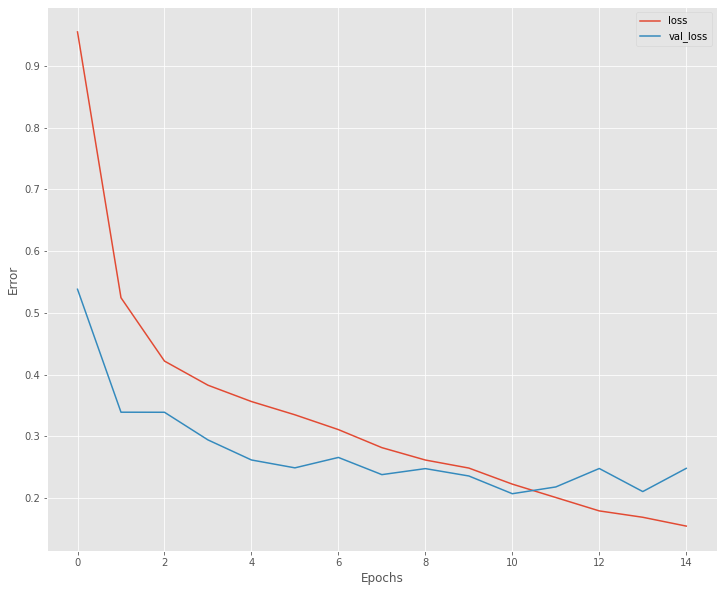

In [0]:
plt.figure(figsize=[12,10])
plt.style.use('ggplot')

plt.plot(classifier.history['loss'], label='loss')
plt.plot(classifier.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(loc='best')
plt.savefig('./loss.png')
plt.show()

### EPOCHS vs ACCURACY

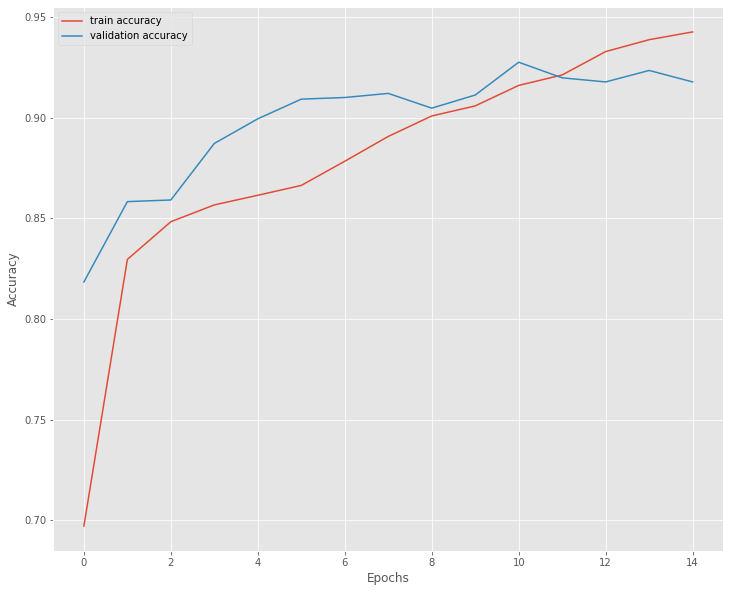

In [0]:
plt.figure(figsize=[12,10])
plt.style.use('ggplot')

plt.plot(classifier.history['accuracy'], label='train accuracy')
plt.plot(classifier.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('./accuracy.png')
plt.show()

### TESTING ACCURACY

In [0]:
print(model.evaluate(x_test, y_test, batch_size=BATCH_SIZE))

1365/1365 [==============================] - 5s 4ms/step
[0.2533527545193333, 0.9172161221504211]


### CLASSIFICATION REPORT

In [0]:
preds = model.predict(x_test).argmax(axis=1)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
preds = ohe.fit_transform(preds.reshape((-1,1))).toarray()

In [0]:
from sklearn.metrics import classification_report
target_names = ['class W', 'class 1', 'class 2', 'class 3/4', 'class R']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

     class W       0.98      0.98      0.98       908
     class 1       0.50      0.35      0.41        63
     class 2       0.89      0.88      0.89       241
   class 3/4       0.76      0.85      0.80        60
     class R       0.70      0.78      0.74        93

   micro avg       0.92      0.92      0.92      1365
   macro avg       0.77      0.77      0.76      1365
weighted avg       0.91      0.92      0.91      1365
 samples avg       0.92      0.92      0.92      1365



In [0]:
def plot_confusion_matrix_custom(cm, classes, normalize=False, title='Confusion matrix', cmap='Reds'):
  import itertools
  plt.figure(figsize=[10,8])
  plt.axis('off')
  # plt.grid(b=None)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

### CONFUSION MATRIX

Confusion matrix, without normalization
[[893   9   0   0   6]
 [ 10  22  12   0  19]
 [  1   5 213  16   6]
 [  1   0   8  51   0]
 [  5   8   7   0  73]]


<Figure size 576x504 with 0 Axes>

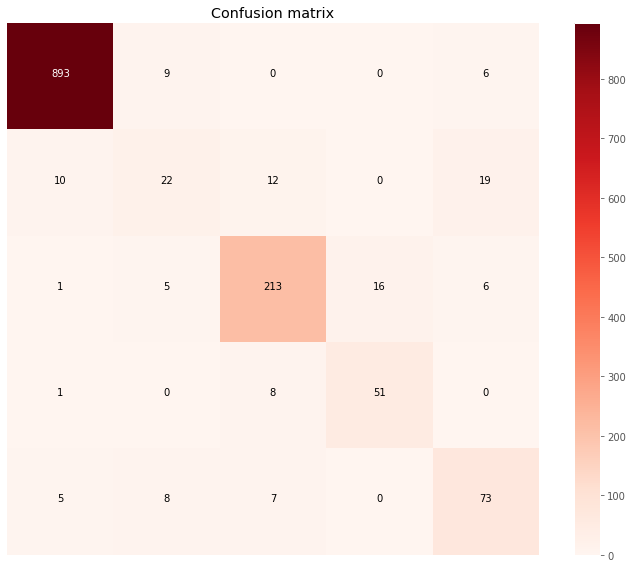

In [0]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
confusion_matrix_output =confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

plt.figure(figsize=[8,7])
plot_confusion_matrix_custom(confusion_matrix_output, classes=['class W', 'class 1', 'class 2', 'class 3/4', 'class R'],
                      title='Confusion matrix')

### ROC

In [0]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle
def plot_custom_roc(y_test, preds):
  n_classes = 5
  lw = 2
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=[10,10])
  classes=['class W', 'class 1', 'class 2', 'class 3/4', 'class R']
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
  for i, color in zip(range(n_classes), colors):
      class_name = classes[i]
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(class_name, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

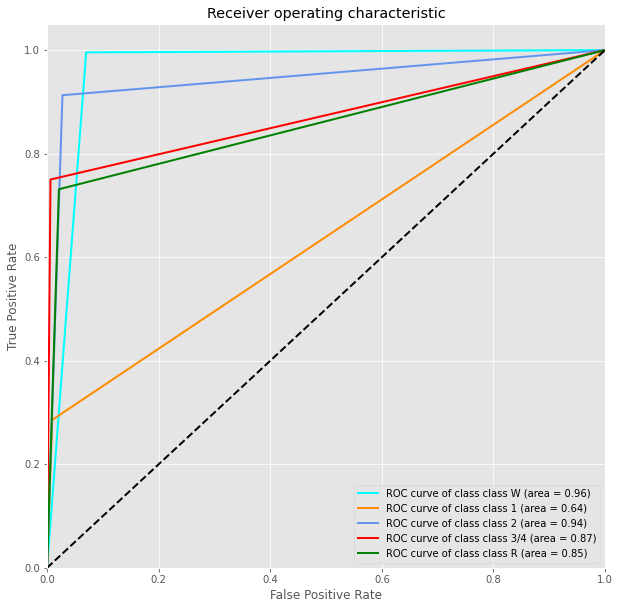

In [0]:
plot_custom_roc(y_test, preds)